# Task: Physics-informed neural networks
#### The static, linear Euler-Bernoulli beam

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Content creators: Jasper O. Schommartz

Summer term 2024

---

#### In this notebook, you learn...

* to nondimensionalize the governing equation of the non-linear Euler-Bernoulli beam.
* to implement PINNs four coupled problems.
* learn some of the challenges associated with PINN training.

In [1]:
from os.path import join
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

K = tf.keras.backend
K.clear_session()


# Data path for local execution
path = 'data'

C:\Users\schommartz\AppData\Local\Temp\ipykernel_10888\155626210.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


*Run the following two cells to clone the GitHub repository in your current Google Colab environment*

In [ ]:
!git clone https://github.com/CPShub/LecturePhysicsAwareML.git

In [ ]:
# Data path for execution in Google Colab
path = join('LecturePhysicsAwareML', 'PINNs', 'data')

*Run the following cell to remove the clones repository.*

In [ ]:
%rm -rf LecturePhysicsAwareML

## Theory of the geometrically non-linear Euler-Bernoulli beam

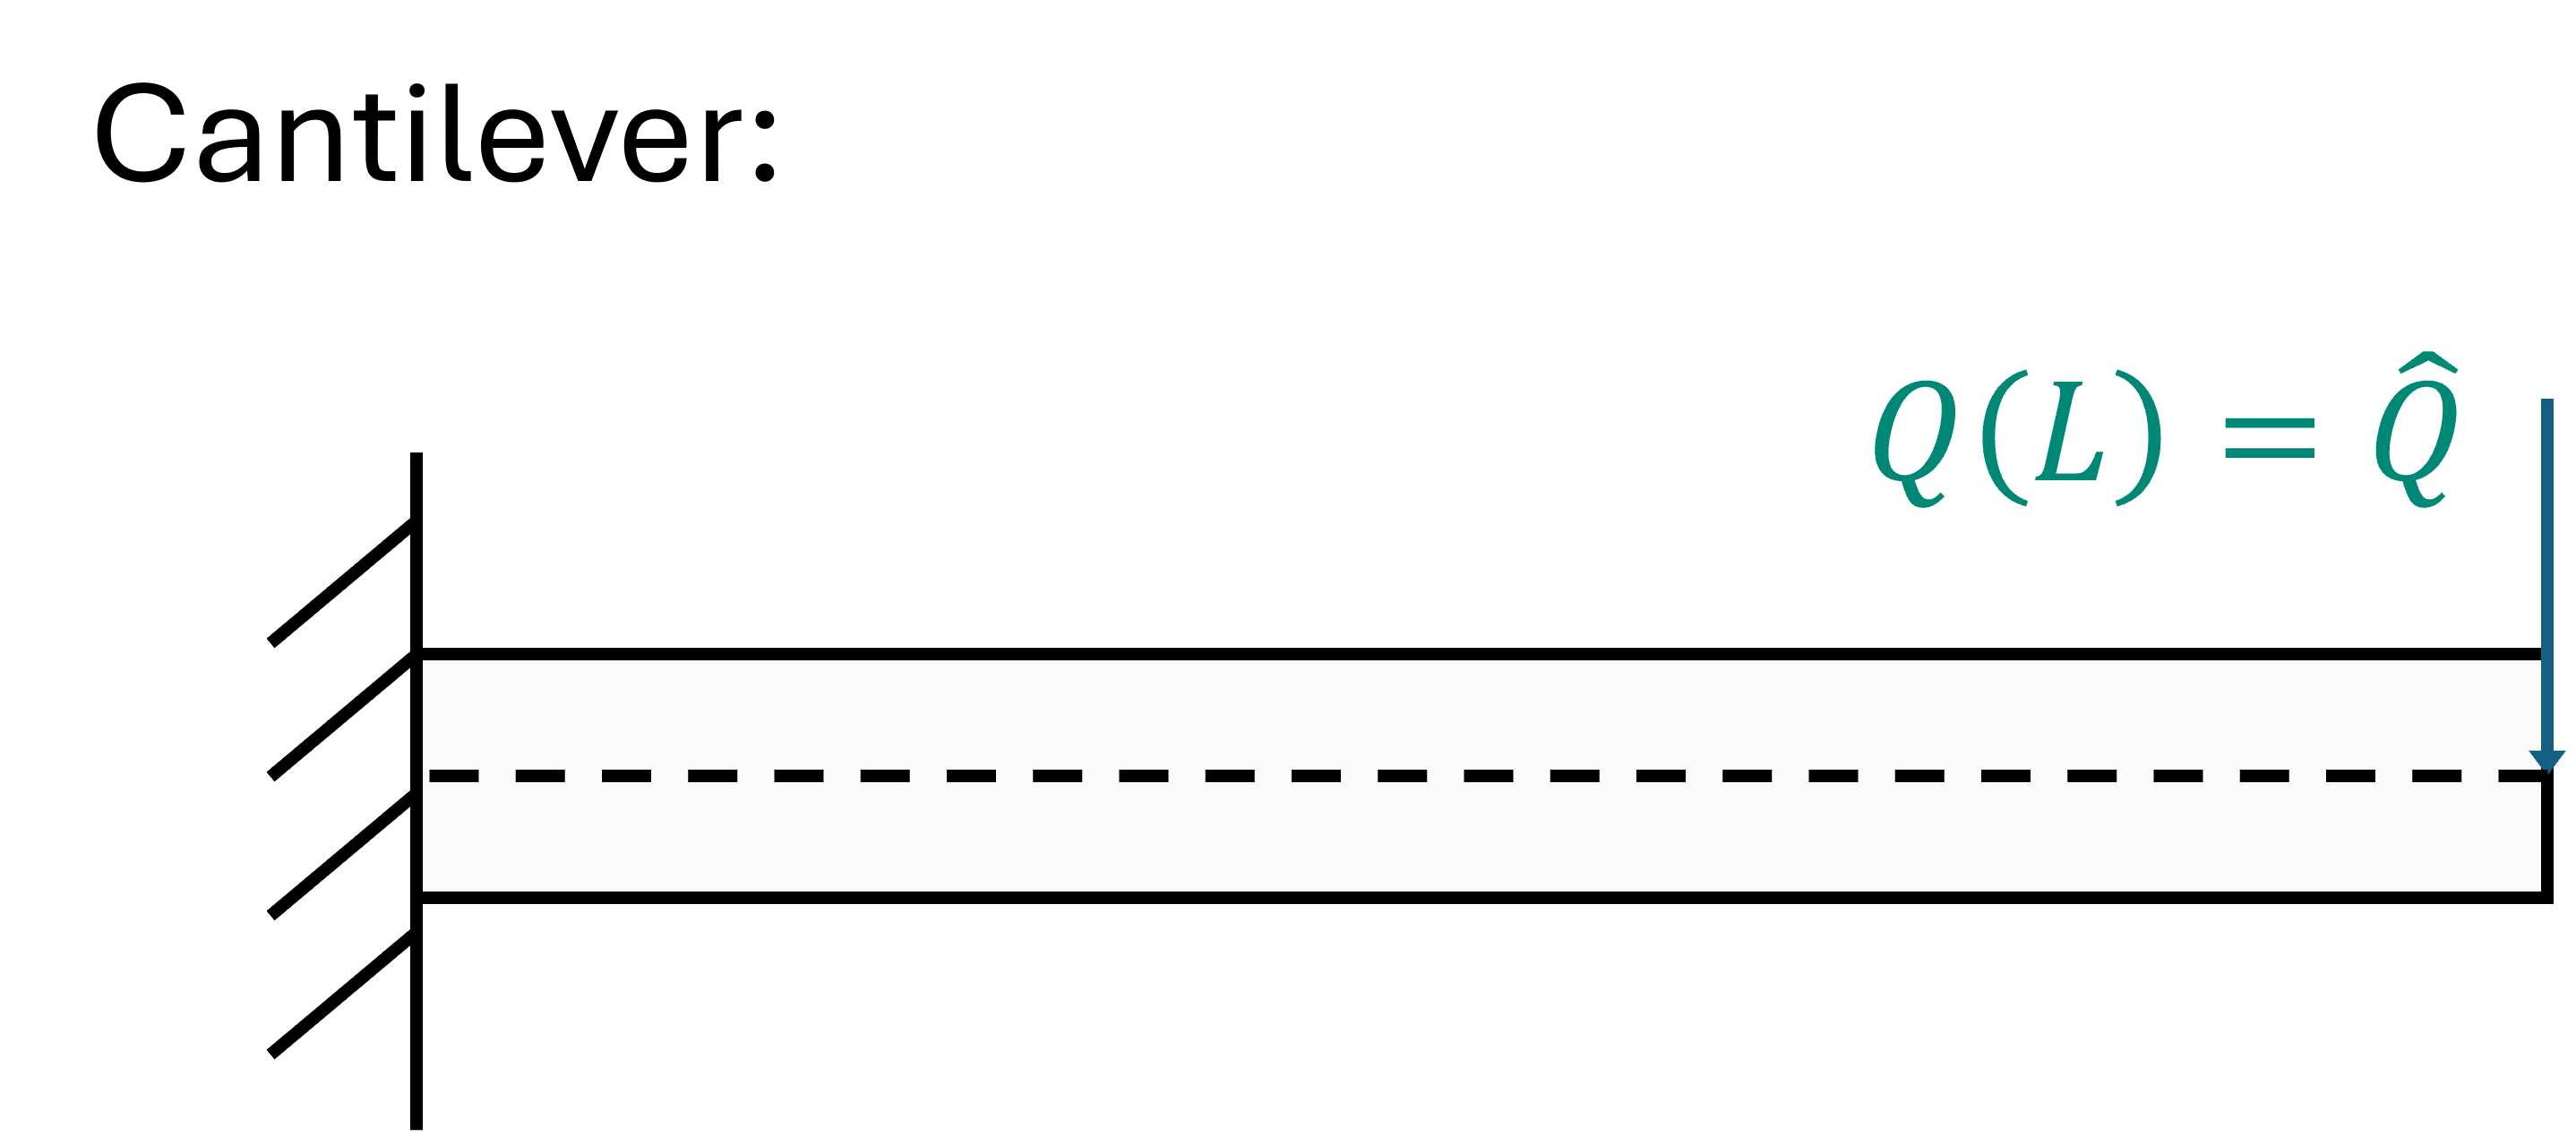

The quasi-static behavior of the beam is described by the following set of partial differential equations (PDEs).

$$
- EA (u'' + w' w'') = f(x) \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad (1)
$$
$$
- EA (u'' w' + u' w'' + \frac{3}{2} w'' (w')^2) + EI w^{(4)} = q(x) \quad\quad(2)
$$

The first equation corresponds to horiontal balance of forces. It is a linear, second order PDE. The second equation corresponds to the vertical balance of forces, which is a nonlinear forth order PDE. The boundary value problem (BVP) for a cantilever beam is completed with the following set of Dirichlet and Neumann boundary conditions:

$$
u(0) = 0,\quad w(0) = 0,\quad w'(0) = 0
$$

$$
Q(L) = \hat{Q} = N w' + M',\quad M(L) = 0, \quad N(L) = 0.
$$

Here, $Q$, $N = EA (u' + 0.5 (w')^2)$ and $M = - E I w^{(4)}$ correspond to the resulting horizontal and vertical internal forces as well as the bending moment in the beam under the assumption of small angles, i.e., $\sin(\varphi) \approx w'$.

### Analytical solution

The BVP for the nonlinear cantilever beam can be solved analytically for $q(x) = f(x) = 0$. Inserting Eq.(1) in Eq.(2) simplifies Eq.(2) to

$$
- EA (u' w'' + w'' (w')^2) + EI w^{(4)} = q(x) \quad\quad(2^*).
$$

With $N(L) = 0$ we can conclude $N(x) = 0$ and Eq.($2^*$) simplifies even further to

$$
EI w^{(4)} = q(x) \quad\quad(2^{**}).
$$

Eq.($2^{**}$) exactly corresponds to the linear Euler-Bernoulli beam, which can be solved analytically before inserting the solution into Eq.(1).

#### Non-dimensionalization

For the calibration of a PINN it can be benefitial to non-dimensionalze the PDEs to assure that the constituents of the loss function are in similar orders of magnitude. Therefore, we introduce the non-dimensional variables $\hat{x}$ and $\hat{w}$ as

$$
x = x_c \cdot \hat{x},\quad u = u_c \cdot \hat{x}, \quad w = w_c \cdot \hat{x}
$$

By choosing $x_c = L$ and inserting the dimensionless into the PDEs the factors

$$
x_c = L,\quad u_c = \frac{I}{AL},\quad w_c = \sqrt{\frac{I}{A}}
$$

are obtained. The nondimensional system of PDEs now reads.

$$
- \hat{u}'' + \hat{w}' \hat{w}'' = \frac{x_c^2}{E A u_c} f(x_c \cdot \hat{x})
$$
$$
-\hat{w}'' \hat{u}' - \frac{3}{2} \hat{w}'' (\hat{w}')^2 - \hat{w}' \hat{u}'' + \hat{w}^{(4)} = \frac{x_c^3}{E A w_c u_c} q(x_c \cdot \hat{x})
$$

For the implementation we set $q(x)= f(x) = 0$. The nondimensional boundary conditions are

$$
\hat{u}(0) = 0,\quad \hat{w}(0) = 0,\quad \hat{w}'(0) = 0
$$

$$
\frac{Q(L)}{\hat{Q}} - 1 = 0,\quad \hat{w}''(0) = 0, \quad N(L) \frac{x_c}{EA u_c} = 0.
$$

## PINN model

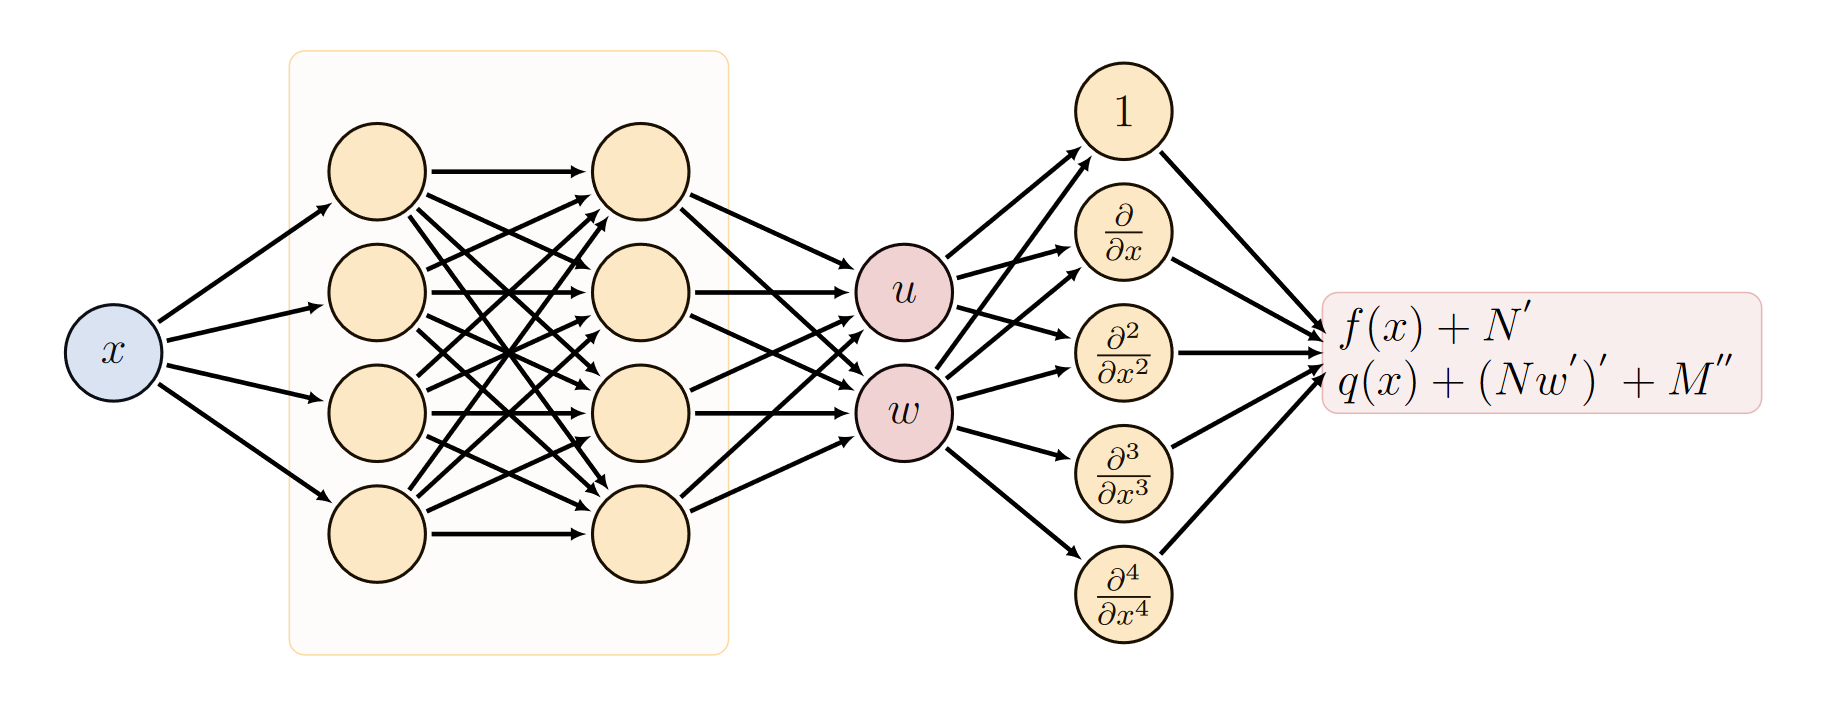

PINNs enforce the physicality of the solution in a weak manner via the loss $\mathcal{L}$. In its simplest form the loss consits of three parts and reads

$$
\mathcal{L} = \mathcal{L}_{data} + \mathcal{L}_{PDE} + \mathcal{L}_{BC}.
$$

Here, $\mathcal{L}_{data}$, denotes the error on a set of labeled data, $\mathcal{L}_{PDE}$ denotes the error of the underlying partial differential equations, and $\mathcal{L}_{BC}$ is the error of the boundary conditions.

Since we need to satiefy two partial differential equations (horziontal and vertial), six boundary conditions and the labeled data, **nine objectives** need to be minimized simultaneously by the optimizer. 


**Implementaion**

The architecture and loss function presented above can be implemented as follows: First, we create a Tensorflow layer for the FFNN, i.e., `MLP`, and functions for the first to fourth derivatives with respect to $x$, i.e., `gradient()`, `second_gradient()`, `third_gradient()` and `fourth_gradient()`.

In [2]:
class MLP(layers.Layer):
    ''' A feed-forward neural network '''
    def __init__(self, units, activation):
        super().__init__()
        self.ls = []
        for (u, a) in zip(units, activation):
            self.ls += [layers.Dense(u, a)]

    def call(self, x):    
        for l in self.ls:
            x = l(x)
        return x

def gradient(f, x):
    ''' Computes the first derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u = f(x)
    du = tf.squeeze(g.batch_jacobian(u, x), 2)
    return u, du

def second_gradient(f, x):
    ''' Computes the second derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u, du = gradient(f, x)
    ddu = tf.squeeze(g.batch_jacobian(du, x), 2)
    return u, du, ddu

def third_gradient(f, x):
    ''' Computes the third derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u, du, ddu = second_gradient(f, x)
    dddu = tf.squeeze(g.batch_jacobian(ddu, x), 2)
    return u, du, ddu, dddu

def fourth_gradient(f, x):
    ''' Computes the fourth derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u, du, ddu, dddu = third_gradient(f, x)
    ddddu = tf.squeeze(g.batch_jacobian(dddu, x), 2)
    return u, du, ddu, dddu, ddddu

In [3]:
class NondimPINN(layers.Layer):
    def __init__(self, w_pde, w_dir, w_neu, w_data, E, A, I, L, labeled_data, **kwargs):
        super().__init__()
        # Create a FFNN
        self.mlp = MLP(**kwargs)

        # Weights
        self.w_pde= tf.constant(w_pde, dtype=tf.float32)
        self.w_dir = tf.constant(w_dir, dtype=tf.float32)
        self.w_neu = tf.constant(w_neu, dtype=tf.float32)
        self.w_data = tf.constant(w_data, dtype=tf.float32)

        # Beam parameters
        self.EA = tf.constant(E * A, dtype=tf.float32)
        self.EI = tf.constant(E * I, dtype=tf.float32)

        # Nondimensional parameters
        self.x_c = tf.constant(L, dtype=tf.float32)
        self.u_c = tf.constant(I / (A * L), dtype=tf.float32)
        self.w_c = tf.constant(tf.sqrt(I / A), dtype=tf.float32)

        # Nondimensional PDE factors
        self.c_1 = self.x_c ** 2 / (self.EA * self.u_c)
        self.c_2 = self.x_c ** 3 / (self.EA * self.w_c * self.u_c)

        # Dirichlet condition
        self.zero = tf.zeros([1,1])
        self.L = tf.ones([1,1]) * L

        # Neumann boundary condition
        self.Q_ext = tf.constant(-10., dtype=tf.float32)

        # Labeled data of the form [x, [u, w]]
        self.labeled_data_x = tf.constant(labeled_data[0], dtype=tf.float32) / self.x_c
        self.labeled_data_u = tf.multiply(
            tf.constant(labeled_data[1], dtype=tf.float32), [self.u_c ** (-1), self.w_c ** (-1)]
        )

    def call(self, x):
        # nondimensionalize input
        x = x / self.x_c

        # evaluate MLP and outputs
        u, du, ddu, dddu, ddddu = fourth_gradient(self.mlp, x)
        N = self._horizontal_force(
            du=tf.gather(du, [0], axis=1),
            dw=tf.gather(du, [1], axis=1)
        )
        M = self._moment(tf.gather(ddu, [1], axis=1))
        Q = self._vertical_force(
            N=N,
            dw=tf.gather(du, [1], axis=1),
            dddw=tf.gather(dddu, [1], axis=1),
        )

        # pde residuals
        res_h = self._horizontal_residual(
            dw = tf.gather(du, [1], axis=1),
            ddu = tf.gather(ddu, [0], axis=1),
            ddw = tf.gather(ddu, [1], axis=1)
        )
        res_v = self._vertical_residual(
            du= tf.gather(du, [0], axis=1),
            dw = tf.gather(du, [1], axis=1),
            ddu = tf.gather(ddu, [0], axis=1),
            ddw = tf.gather(ddu, [1], axis=1),
            ddddw = tf.gather(ddddu, [1], axis=1)
        )
        res_pde_1 = tf.reduce_mean(tf.square(res_h))
        res_pde_2 = tf.reduce_mean(tf.square(res_v))

        u0, du0 = gradient(self.mlp, self.zero)
        _, duL, dduL, ddduL = third_gradient(self.mlp, self.L / self.x_c)

        # Dirichlet boundary condition residuals
        res_dir_1 = tf.square(tf.gather(u0, [0], axis=1))
        res_dir_2 = tf.square(tf.gather(u0, [1], axis=1))
        res_dir_3 = tf.square( tf.gather(du0, [1], axis=1))

        # Neumann boundary condition residuals
        NL = self._horizontal_force(
            du=tf.gather(duL, [0], axis=1),
            dw=tf.gather(duL, [1], axis=1)
        )
        ML = self._moment(tf.gather(dduL, [1], axis=1))
        QL = self._vertical_force(
            N=NL,
            dw=tf.gather(duL, [1], axis=1),
            dddw=tf.gather(ddduL, [1], axis=1),
        )
        res_neu_1 = tf.square(NL / self.EA / self.u_c * self.x_c)
        res_neu_2 = tf.square(1 - QL / self.Q_ext)
        res_neu_3 = tf.square(ML / self.EI / self.w_c * tf.square(self.x_c))

        # labeled data residual
        res_u, res_w = self._labeled_data_residual()

        # add loss term
        total_loss = (
            (res_pde_1 * self.w_pde[0] + res_pde_2 * self.w_pde[1]) / 2
            + (res_dir_1 * self.w_dir[0] + res_dir_2 * self.w_dir[1] + res_dir_3 * self.w_dir[2]) / 3
            + (res_neu_1 * self.w_neu[0] + res_neu_2 * self.w_neu[1] + res_neu_3 * self.w_neu[2]) / 3
            + (res_u * self.w_data[0] + res_w * self.w_data[1]) / 2
        )
        self.add_loss(total_loss)

        return (tf.multiply(u, [self.u_c, self.w_c]),
                N, Q, M,
                res_h / self.c_1, res_v / self.c_2,
                res_pde_1, res_pde_2,
                res_dir_1, res_dir_2, res_dir_3,
                res_neu_1, res_neu_2, res_neu_3,
                res_u, res_w)
    
    def _horizontal_residual(self, dw, ddu, ddw):
        ''' Computes the residual of the balances of forces'''
        return ddu + dw * ddw
    
    def _vertical_residual(self, du, dw, ddu, ddw, ddddw):
        ''' Computes the residual of balance of moments'''
        return ddu * dw + du * ddw + 1.5 * ddw * tf.square(dw) - ddddw
        # return ddu * dw + ddw * tf.square(dw) - ddddw
        #return - ddddw

    def _labeled_data_residual(self):
        ''' Computes the data loss using the mean squared error '''
        u = self.mlp(self.labeled_data_x)
        res_u = tf.reduce_mean(tf.square(tf.gather(u, [0], axis=1) - tf.gather(self.labeled_data_u, [0], axis=1)))
        res_w = tf.reduce_mean(tf.square(tf.gather(u, [1], axis=1) - tf.gather(self.labeled_data_u, [1], axis=1)))
        return res_u, res_w

    def _horizontal_force(self, du, dw):
        ''' Computes the normal force '''
        return self.EA * self.u_c / self.x_c * (du +  0.5 * tf.square(dw))
    
    def _moment(self, ddw):
        ''' Computes the bending moment '''
        return - self.EI * self.w_c / tf.square(self.x_c) * ddw
    
    def _vertical_force(self, N, dw, dddw):
        ''' Computed the vertical resulting force '''
        return self.w_c / self.x_c * N * dw - self.EI * self.w_c / tf.math.pow(self.x_c, 3) * dddw

In [4]:
def build(*args, **kwargs):
    ''' Builds an evaluation model that returns the nodal displacements '''
    # define input shape
    x = tf.keras.Input(shape=(1,))
    # define which (custom) layers the model uses
    pinn = NondimPINN(*args, **kwargs)
    out = pinn(x)
    # connect input and output
    model = tf.keras.Model(inputs = [x], outputs = list(out))
    # define optimizer
    model.compile('adam')
    return model

## Load data

In [ ]:
def load_data(fname):
    # Simulation properties
    L = 0.2
    n = 201

    # Auxiliary function
    convert = lambda x: tf.expand_dims(tf.convert_to_tensor(x, dtype=tf.float32), 1)
    
    # Load time series from quasi-static simulation to data frame
    # but only save the last time step.
    arr = pd.read_csv(fname, sep='\t', header=None).transpose().to_numpy()[-1,:]

    # Convert to tensors
    x = convert(np.linspace(0, L, n))
    u = convert(arr[np.arange(0, n * 4, 4)])
    w = convert(arr[np.arange(1, n * 4, 4)])
    du = convert(arr[np.arange(2, n * 4, 4)])
    dw = convert(arr[np.arange(3, n * 4, 4)])

    # Concatenate displacements and derivatives
    u = tf.concat([u, w], axis=1)
    du = tf.concat([du, dw], axis=1)
    
    return x, u, du

def plot_data(x, u, du):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].plot(x, u[:, 0], 'b', linestyle='--')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('u')
    axs[0, 0].grid()

    axs[0, 1].plot(x, u[:, 1], 'b', linestyle='--')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('w')
    axs[0, 1].grid()

    axs[1, 0].plot(x, du[:, 0], 'b', linestyle='--')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('du')
    axs[1, 0].grid()

    axs[1, 1].plot(x, du[:, 1], 'b', linestyle='--')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('dw')
    axs[1, 1].grid()
    
    fig.suptitle('Labeled data', fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# Load data from beam simulation
fname = 'dataU0.dat'
x, u, du = load_data(join(path, fname))

# Plot data
plot_data(x, u, du)

## Build model

In [ ]:
# Beam properties
L = 0.2            # Length [m]
W = 0.02           # Width [m]
H = 0.02           # Height [m]
E = 50e6           # Young's modulus [Pa]

# Cross-section parameters
A = W * H
I = H ** 3 * W / 12

# Loss weights
WPDE = [1., 1.]      # 0: horizontal balance, 1: vertical balance
WDIR = [1., 1., 1.]  # 0: u(0) = 0, 1: w(0) = 0, 2: w'(0) = 0
WNEU = [1., 1., 1.]  # 0: Fh(L) = 0, 1: Fv(L) = 0, 2: M(L) = 0
WDATA = [0., 0.]

# Load model
model = build(WPDE, WDIR, WNEU, WDATA, E, A, I, L,
    labeled_data=[x, u],
    units=[16, 2],
    activation=['softplus', 'linear']
)
model.summary()

## Model calibration

In [ ]:
# Create collocation points
NCAL = 200 # number of collocation points
x_cal = tf.expand_dims(tf.convert_to_tensor(np.linspace(0, L, NCAL), dtype=tf.float32), 1)

# Calibrate model
NEPOCHS = 10000
model.optimizer.learning_rate.assign(0.001)
h = model.fit([x_cal],
            epochs=NEPOCHS,
            verbose=2,
            batch_size=32)

plt.semilogy(np.linspace(1, NEPOCHS, NEPOCHS), h.history['loss'], label='training loss')
plt.grid(which='both')
plt.legend()
plt.show()

# Save weights
model.save_weights('weights_nlebb.h5')

In [ ]:
# Load weights to skip the training
model.load_weights('weights_nlebb.h5')

## Evaluation

In [ ]:
# def plot(x, u, u_pred, Fh_pred, Fv_pred, M_pred, res_h, res_v):
def plot(x, u, pred):
    # Plot data and prediction
    fig, axs = plt.subplots(4, 2, figsize=(10, 16))
    axs[0, 0].plot(x, pred[0][:, 0], 'r', label='PINN')
    axs[0, 0].plot(x, u[:, 0], 'b', linestyle='--', label='FEM')
    axs[0, 0].set_title('Horizontal displacement')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('u')
    axs[0, 0].grid()
    axs[0, 0].legend()

    axs[0, 1].plot(x, pred[0][:, 1], 'r', label='PINN')
    axs[0, 1].plot(x, u[:, 1], 'b', linestyle='--', label='FEM')
    axs[0, 1].set_title('Vertical displacement')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('w')
    axs[0, 1].grid()
    axs[0, 1].legend()

    axs[1, 0].plot(x, pred[1], 'r', label='PINN')
    axs[1, 0].set_title('Horizontal internal force')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('Fh')
    axs[1, 0].grid()
    axs[1, 0].legend()

    axs[1, 1].plot(x, pred[2], 'r', label='PINN')
    axs[1, 1].set_title('Vertical internal force')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('Fv')
    axs[1, 1].grid()
    axs[1, 1].legend()

    axs[2, 0].plot(x, pred[3], 'r', label='PINN')
    axs[2, 0].set_title('Internal bending moment')
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel('M')
    axs[2, 0].grid()
    axs[2, 0].legend()

    axs[2, 1].plot(x, pred[4], 'r', label='Horizontal')
    axs[2, 1].plot(x, pred[5], 'b', label='Vertical')
    axs[2, 1].set_title('PDE residuals')
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel('Residual')
    axs[2, 1].grid()
    axs[2, 1].legend()

    x = [tf.squeeze(x) for x in pred[6:]]
    labels = ['PDE1', 'PDE2', 'DIR1', 'DIR2', 'DIR3', 'NEU1', 'NEU2', 'NEU3', 'u', 'w']
    axs[3, 0].bar(labels, x)
    axs[3, 0].set_title('Loss terms')
    axs[3, 0].set_xlabel('x')
    axs[3, 0].set_ylabel('Value')
    axs[3, 0].set_yscale('log')
    axs[3, 0].grid()
    axs[3, 0].legend()

    axs[3, 1].axis('off')

    plt.tight_layout()
    plt.show()

def plot_deformation(u, u_pred):
    fig, ax = plt.subplots()
    ax.plot(tf.squeeze(x) + u_pred[:, 0], u_pred[:, 1], 'r', label='PINN')
    ax.plot(tf.squeeze(x) + u[:, 0], u[:, 1], 'b', label='FEM')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title('Deformed beam')
    ax.grid()
    ax.legend()

In [ ]:
# Get model predictions
pred = model(x)

# Plot data and prediction
plot(x, u, pred)

# Plot deformed beam
plot_deformation(u, pred[0])